In [1]:
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import keras.backend as K

from keras.models import Sequential, load_model  
from keras.layers.core import Dense, Activation  
from keras.layers import LSTM, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Input,Dense, LSTM,TimeDistributed, Flatten, Reshape
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import Nadam
from keras import optimizers
from keras.layers.normalization import BatchNormalization

%matplotlib inline
datapath = 'Data/NewNoise SNR neg10 101pts Pickle/'

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Data Preprocessing
### Data files can be downloaded from [here](https://drive.google.com/drive/folders/1Ygpg6PwQ9KiXTlbuUBQQffuqpjrBx97G?usp=sharing)

Data/NewNoise SNR neg10 101pts Pickle/x_train.p (35000, 75) (15000, 75)
(35000, 75) (35000,) (15000, 75) (15000,) (500, 75) (500,)


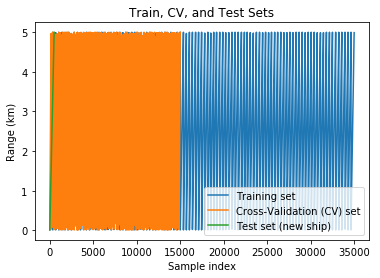

In [2]:
xtrains = sorted(glob.glob(datapath+'x_train.p')) #+ sorted(glob.glob(datapath+'x_train_VLA2_Mar25_Y*'))
ytrains = sorted(glob.glob(datapath+'y_train.p'))# + sorted(glob.glob(datapath+'y_train_VLA2_Mar25_Y*'))
xvals = sorted(glob.glob(datapath+'x_val.p')) #+ sorted(glob.glob(datapath+'x_test_VLA2_Mar25_Y*'))
yvals = sorted(glob.glob(datapath+'y_val.p'))# + sorted(glob.glob(datapath+'y_test_VLA2_Mar25_Y*'))



# intialize
Kinput = pickle.load(open(xtrains[0],'rb'))
X_training = np.empty([0,Kinput.shape[1]])
Y_training = np.empty([0,])
X_val = np.empty([0,Kinput.shape[1]])
Y_val = np.empty([0,])
X_test = pickle.load(open(datapath+'x_test.p','rb'))
Y_test = pickle.load(open(datapath+'y_test.p','rb'))

for fi in np.arange(0,len(xtrains)):
    X_training_un = pickle.load(open(xtrains[fi],'rb'))
    Y_training_un = pickle.load(open(ytrains[fi],'rb'))
    X_val_un = pickle.load(open(xvals[fi],'rb'))
    Y_val_un = pickle.load(open(yvals[fi],'rb'))
    print(xtrains[fi], X_training_un.shape, X_val_un.shape)

    X_training = np.concatenate((X_training, X_training_un), axis=0)
    Y_training = np.concatenate((Y_training, Y_training_un), axis=0)
    X_val = np.concatenate((X_val, X_val_un), axis=0)
    Y_val = np.concatenate((Y_val, Y_val_un), axis=0)

# Centering and Normalizing data
X_training = X_training[Y_training<15,:]
Y_training = Y_training[Y_training<15]
X_val = X_val[Y_val<15,:]
Y_val = Y_val[Y_val<15]
X_test = X_test[Y_test<15,:]
Y_test = Y_test[Y_test<15]

mux = np.mean(X_training, axis=0)
stdx = np.std(X_training, axis=0)
X_training = (X_training - mux)/stdx
X_val = (X_val - mux)/stdx
X_test = (X_test - mux)/stdx


print(X_training.shape, Y_training.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)
plt.plot(Y_training,label='Training set')
plt.plot(Y_val,label='Cross-Validation (CV) set')
plt.ylabel('Range (km)')
plt.xlabel('Sample index')
plt.title('Train, CV, and Test Sets')
plt.plot(Y_test,label='Test set (new ship)')

plt.legend()

In [ ]:
def get_model(data_dim = 50):
    input_layer = Input(shape=(data_dim,))
    hidden_layer1 = Dense(256, activation="tanh", name="hidden_layer1")(input_layer)
    batch_norm1 = BatchNormalization( name = "batch_norm_1")(hidden_layer1)
    drop1 = Dropout(0.30)(batch_norm1)
    
    hidden_layer2 = Dense(128, activation="tanh", name="hidden_layer2")(drop1)
    batch_norm2 = BatchNormalization( name = "batch_norm_2")(hidden_layer2)
    drop2 = Dropout(0.30)(batch_norm2)
    
    hidden_layer3 = Dense(64, activation="relu", name="hidden_layer3")(drop2)
    batch_norm3 = BatchNormalization( name = "batch_norm_3")(hidden_layer3)
    drop3 = Dropout(0.30)(batch_norm3)
    
    hidden_layer4 = Dense(32, activation="relu", name="hidden_layer4")(drop3)
    batch_norm4 = BatchNormalization( name = "batch_norm_4")(hidden_layer4)
    drop4 = Dropout(0.30)(batch_norm4)
    
    hidden_layer5 = Dense(32, activation="relu", name="hidden_layer5")(drop4)
    batch_norm5 = BatchNormalization( name = "batch_norm_5")(hidden_layer5)
    drop5 = Dropout(0.30)(batch_norm5)
    
    hidden_layer6 = Dense(32, activation="relu", name="hidden_layer6")(drop5)
    batch_norm6 = BatchNormalization( name = "batch_norm_6")(hidden_layer6)
    drop6 = Dropout(0.30)(batch_norm6)
    
    output_layer = Dense(1, activation="linear")(drop3)
    model = Model(inputs = input_layer, output = output_layer)
    
    return model

## Training

In [ ]:
n_epochs = 500
data_dim = X_training.shape[1]
optimizer = optimizers.RMSprop(lr=1e-4)#, beta_1=0.9, beta_2=0.999, epsilon=1e-08)#, schedule_decay=0.004)
model = get_model(data_dim)
model.compile(loss="mean_squared_error", optimizer=optimizer)

batch_size = 50
L=len(X_training)
val_data = (X_val, Y_val)
history = model.fit(X_training, Y_training, batch_size=batch_size, epochs=n_epochs, validation_data=val_data)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 35000 samples, validate on 15000 samples
Epoch 1/500
35000/35000 [==============================] - 4s 119us/step - loss: 7.4124 - val_loss: 4.6202
Epoch 2/500
35000/35000 [==============================] - 4s 104us/step - loss: 4.0329 - val_loss: 2.0644
Epoch 3/500
35000/35000 [==============================] - 4s 100us/step - loss: 2.2780 - val_loss: 0.8881
Epoch 4/500
35000/35000 [==============================] - 4s 102us/step - loss: 1.6695 - val_loss: 0.6422
Epoch 5/500
35000/35000 [==============================] - 4s 105us/step - loss: 1.4124 - val_loss: 0.5663
Epoch 6/500
35000/35000 [==============================] - 3s 98us/step - loss: 1.2235 - val_loss: 0.4937
Epoch 7/500
35000/35000 [==============================] - 3s 99us/step - loss: 1.0762 - val_loss: 0.4330
Epoch 8/500
35000/35000 [==============================] - 3s 97us/step - loss: 0.9646 - val_loss: 0.3894
Epoch 9/500
35000/35000 [==============================] - 3s 99us/step - loss: 0.8672 - val_loss

35000/35000 [==============================] - 4s 113us/step - loss: 0.2098 - val_loss: 0.0466
Epoch 78/500
35000/35000 [==============================] - 4s 125us/step - loss: 0.2070 - val_loss: 0.0436
Epoch 79/500
35000/35000 [==============================] - 4s 122us/step - loss: 0.2106 - val_loss: 0.0467
Epoch 80/500
35000/35000 [==============================] - 4s 119us/step - loss: 0.2034 - val_loss: 0.0464
Epoch 81/500
35000/35000 [==============================] - 4s 114us/step - loss: 0.2046 - val_loss: 0.0436
Epoch 82/500
35000/35000 [==============================] - 4s 112us/step - loss: 0.2053 - val_loss: 0.0429
Epoch 83/500
35000/35000 [==============================] - 4s 113us/step - loss: 0.2042 - val_loss: 0.0426
Epoch 84/500
35000/35000 [==============================] - 4s 106us/step - loss: 0.2011 - val_loss: 0.0435
Epoch 85/500
35000/35000 [==============================] - 4s 101us/step - loss: 0.2033 - val_loss: 0.0447
Epoch 86/500
35000/35000 [===============

35000/35000 [==============================] - 3s 98us/step - loss: 0.1635 - val_loss: 0.0304
Epoch 154/500
35000/35000 [==============================] - 3s 98us/step - loss: 0.1573 - val_loss: 0.0307
Epoch 155/500
35000/35000 [==============================] - 3s 97us/step - loss: 0.1602 - val_loss: 0.0296
Epoch 156/500
35000/35000 [==============================] - 3s 97us/step - loss: 0.1601 - val_loss: 0.0291
Epoch 157/500
35000/35000 [==============================] - 3s 99us/step - loss: 0.1576 - val_loss: 0.0281
Epoch 158/500
35000/35000 [==============================] - 3s 98us/step - loss: 0.1563 - val_loss: 0.0291
Epoch 159/500
35000/35000 [==============================] - 3s 97us/step - loss: 0.1575 - val_loss: 0.0313
Epoch 160/500
35000/35000 [==============================] - 3s 98us/step - loss: 0.1624 - val_loss: 0.0273
Epoch 161/500
35000/35000 [==============================] - 3s 97us/step - loss: 0.1563 - val_loss: 0.0280
Epoch 162/500
35000/35000 [===============

Epoch 229/500
35000/35000 [==============================] - 3s 99us/step - loss: 0.1351 - val_loss: 0.0244
Epoch 230/500
35000/35000 [==============================] - 3s 99us/step - loss: 0.1349 - val_loss: 0.0226
Epoch 231/500
35000/35000 [==============================] - 3s 97us/step - loss: 0.1350 - val_loss: 0.0235
Epoch 232/500
35000/35000 [==============================] - 3s 98us/step - loss: 0.1336 - val_loss: 0.0239
Epoch 233/500
35000/35000 [==============================] - 3s 98us/step - loss: 0.1375 - val_loss: 0.0238
Epoch 234/500
35000/35000 [==============================] - 3s 96us/step - loss: 0.1335 - val_loss: 0.0249
Epoch 235/500
35000/35000 [==============================] - 3s 96us/step - loss: 0.1346 - val_loss: 0.0230
Epoch 236/500
35000/35000 [==============================] - 3s 97us/step - loss: 0.1365 - val_loss: 0.0219
Epoch 237/500
35000/35000 [==============================] - 3s 97us/step - loss: 0.1327 - val_loss: 0.0213
Epoch 238/500
35000/35000 [=

## Testing

In [ ]:
fig = plt.figure()

preds = model.predict(X_val)
preds2 = model.predict(X_training)
preds3 = model.predict(X_test)

In [ ]:
plt.subplot(131)
plt.plot(preds2,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_training,'y',linewidth=1.0)
#plt.legend(['Training Set', 'Ground Truth'])
plt.xlabel('Sample index')
plt.ylabel('Range (km)')
plt.title('Training')

RMSE_Ytrain = np.sqrt(np.mean(np.square(np.abs(Y_training-preds2[:,0]))))


plt.subplot(132)
plt.plot(preds,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_val,'r',linewidth=1.0)
#plt.legend(['Predictions', 'Ground Truth'])
plt.xlabel('Sample index')
#plt.ylabel('Range (km)')
plt.title('Validation')

RMSE_Yval = np.mean(np.abs(Y_val-preds[:,0]))

#plt.subplot(133)
plt.figure()
plt.plot(preds3,'o',color='blue',markersize=2,mew=0.5,mec='blue',markerfacecolor='none')
plt.plot(Y_test,'r',linewidth=1.0)
#plt.plot(Y_training,'y',linewidth=1.0)
plt.legend(['Predictions', 'Ground Truth'])
plt.xlabel('Sample index')
#plt.ylabel('Range (km)')
plt.title('Test (unseen ship)')
plt.savefig('test_noisy_simulation.pdf')
plt.show()


RMSE_Ytest = np.sqrt(np.mean(np.square(np.abs(Y_test-preds3[:,0]))))

MAE = np.mean(np.abs(Y_test-preds3[:,0])/Y_test)
print('Mean relative error' + str(MAE))

print('Training set RMSE = ' + str(RMSE_Ytrain) + ' km')
print('Validation set RMSE = ' + str(RMSE_Yval) + ' km')
print('Test set RMSE = ' + str(RMSE_Ytest) + ' km')

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])



In [ ]:
# # Save model
# model.save('model_mlp.h5')

# # Load saved model
# model = load_model('model_mlp.h5')

## Visualizing Activations

In [ ]:
weights = model.get_weights()
k=0
for i in range(len(weights)):
    shape = weights[i].shape
    if(len(shape)>1):
        fileName = "mlp_weights_layer_{}.png".format(k)
        plt.figure()
        if((shape[0]>1) & (shape[1]>1)):
            plt.imshow(np.abs(weights[i]))
            plt.colorbar()
        else:
            plt.plot(np.abs(weights[i]))   
       # plt.savefig(fileName)
plt.show()

## Visualizing Activations

In [ ]:
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    activations = []
    inp = model.input
    
    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)

    return activations

In [ ]:
test_sample_num = 0
activation_map = get_activations(model, np.reshape(X_test[test_sample_num,:], (1, X_test.shape[1])))
layers = [0, 3]#, 6, 9, 10]
print(activation_map[3].shape)

for key, layer in enumerate(layers):
    
    activations = activation_map[layer][0]
    subplot_num = len(layers)*100 + 1*10 + key+1
    plt.subplot(subplot_num)
    plt.gca().get_yaxis().set_visible(False)
    plt.imshow(np.reshape(activations, (1, len(activations))), interpolation = 'nearest', aspect='auto')
cax = plt.axes([1, 0.1, 0.075, 0.8])
plt.tight_layout()
plt.colorbar(cax=cax)
plt.show()